In [53]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np 
import math 
import os
import csv
import pandas as pd
from PIL import Image
from torchvision.io import read_image
import torchvision.transforms as transforms

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


In [52]:
# Automating the generation of a csv file with all directories, image names and their lables
# ---directory----image_name----binary_category----category

with open('./lables.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(["directory", "image_name", "binary_cat", "multi_cat"])
    
    categories = {
        "healthy": 0,
        "unhealthy" : 1,
        "Anthracnose" : 2,
        "Bacterial Blight": 3,
        "Black Spot": 4,
        "Citrus Canker": 5, 
        "Citrus Hindu Mite":6,
        "Citrus Leafminer":7,
        "Curl Leaf":8,
        "Deficiency":9,
        "Dry Leaf":10,
        "Greening":11,
        "Melanose":12,
        "Sooty Mould":13,
        "Spider Mites":14 
    }
    
    for path, subdirs, files in os.walk('./dataset'):
        if "./dataset/healthy" in path:
            for img in files:
                writer.writerow([os.path.join(path, img), img, categories["healthy"], categories["healthy"]])
        if "./dataset/unhealthy" in path:
            for img in files:
                # path[20:] cut out the unnecessary directory snince we only needthe diseasw name, which is the latter part of the directory
                multi = path[20:]
                writer.writerow([os.path.join(path, img), img, categories["unhealthy"], categories[multi]])
file.close()

In [59]:
class CitrusImageDataset(Dataset):
    """
    A custom dataset class for Citrus leaf image dataset.
    - Resizes images to a specified width and height. 
    - Imaplements methods to get dataset items and dataset length (as reccomended by pytorch documentation)
    - Adds an argument for common transformation for the image dataset

    Args:
        annotations_file: takes in the cvs file that contains lables of images 
        img_dir: direcotry in which images are stored
        mode: 0 for binary classifer, 1 for multi class
        transform: to modify the features, needed to manipulate data to make it suitable for training
        target_transform: to modify the labels - that accept callables containing the transformation logic
        
    """
    def __init__(self, label_type, img_dir, transform=None, target_transform=None):
        data = pd.read_csv('./lables.csv')
        self.img_labels = data[label_type].tolist()
        self.data_paths = data[img_dir].tolist()
        self.transform = transform
        self.target_transform = target_transform
        
            

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        data_path = self.data_paths[idx]
        image = Image.open(data_path)
        label = self.img_labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label


In [60]:
# Defining transformations - using industry standard, can try to customize later
"""
Normalize does: image = (image - mean)/std;  mean for all 3 channels: [0.485, 0.456, 0.406], std for all 3 channels: [0.229, 0.224, 0.225] 
"""
img_transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((224,224)),
               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet's mean and std
])
# options for labels ar binary_cat or multi_cat 
#since labels.csv has all information sorted into columns, I am passing inthe column headers as "directories" which is a little unsuauly from traditional
label_type = 'binary_cat'
img_dir = 'directory'
dataset = CitrusImageDataset(label_type, img_dir,img_transforms)


In [61]:
batch_size = 10
train_size = 2000
test_size = 1513
train_data, test_data = random_split(dataset, [train_size,test_size])

print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(test_data)}")

#WHAT DECINED NUM_WORKERS
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size*2, num_workers = 4, pin_memory = True)

image_datasets = {
    'train': train_data,
    'test': test_data,
}

dataloaders = { 'test': test_dl, 'train': train_dl}


Length of Train Data : 2000
Length of Validation Data : 1513


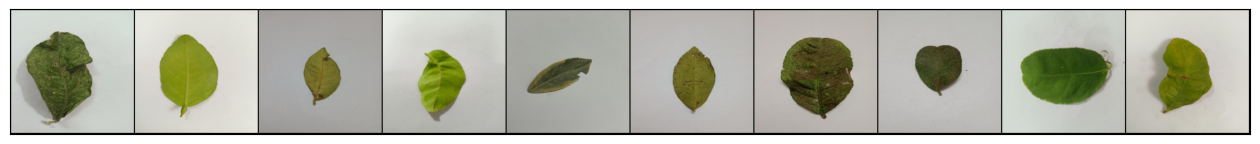

In [62]:

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)